# Group Project 02 

### Solution of falkner skan equation using PINNS ( 1 hidden layer) for a flat plate and stagnation point flow

#### Faulkner - Skan boundary layer equation:(Formulation B)
$\begin{align}
f''' + \frac{(m+1)}{2}ff'' + m(1 - (f')^2) = 0
\end{align}$

#### Necessary libraries were imported initially
#### Parameters like eta , m=0 represents pressure gradient for a flat plate 
#### Activation function used : Tanh()
#### Loss function : MSE is used to compute loss

#### The neural network has an input layer, one hidden layer with 20 neurons and an output layer.

#### Boundary Conditions:
$$\eta = 0 : f(0) = f'(0) = 0$$
$$ \eta --> infinity : f'(eta) = 1 $$

#### Plotted velocity profiles , shear stress profiles , loss vs iterations for both the formulations 

#### Single output f(eta) is calculated , and through automatic differentiation f'(eta) and f"(eta) were found

#### Total loss is the sum of the boundary condition loss and the PDE loss

#### Values for displacement thickness, momentum thickness, shape factor , Wall Skin friction coefficient were shown for all cases

### For Flat plate ( Formulation B ) using PINN 

Iteration 100: Loss = 0.0019459680188447237
Iteration 200: Loss = 3.268366299380432e-06
Total iterations: 279


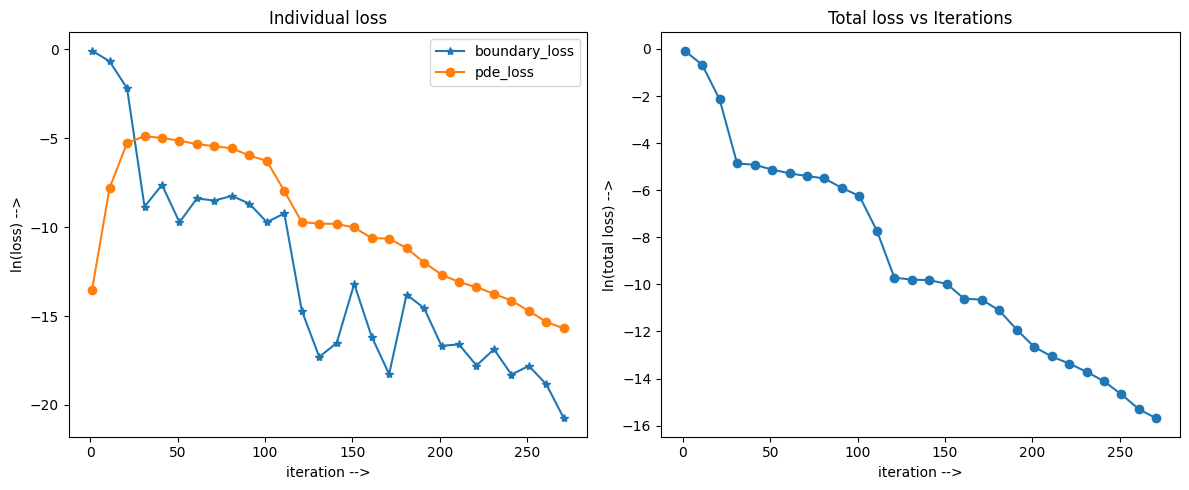

Displacement thickness: 1.7148898839950562
Momentum thickness: 0.6603348851203918
Shape factor: 2.5970003604888916
Wall skin friction coefficient: 0.6651142239570618


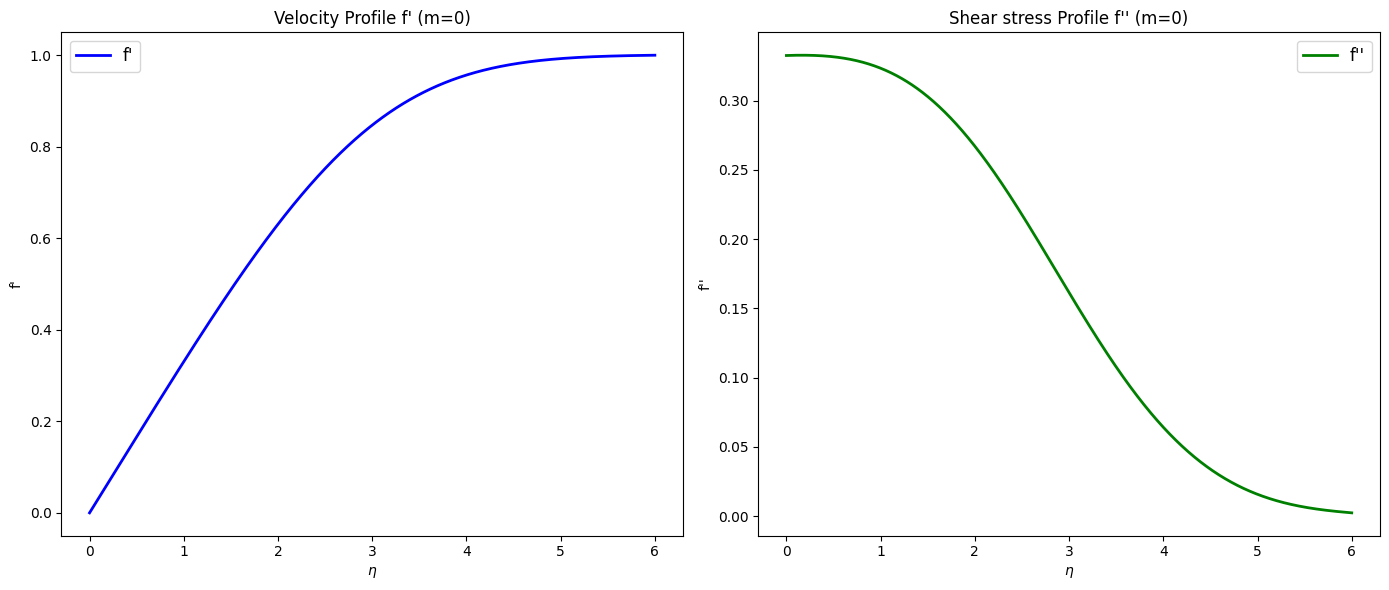

In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim
import numpy as np   
import matplotlib.pyplot as plt
from numpy import trapz 


np.random.seed(941)
torch.manual_seed(11)
eta = np.linspace(0, 6, 1000)[:, None]
eta_min = eta[[0]]
eta_max = eta[[-1]]

 # flat plate case
m = 0 
bc = eta[[0, -1]]
f_bc = np.array([[0],[1]])


eta = torch.from_numpy(eta).float()
eta_min = torch.from_numpy(eta_min).float()
eta_max = torch.from_numpy(eta_max).float()
bc = torch.from_numpy(bc).float()
f_bc = torch.from_numpy(f_bc).float()

class NN(nn.Module):
    
    def __init__(self, layers):
        super().__init__()
        
        # activation function
        self.activation = nn.Tanh()

        # loss function
        self.loss_function = nn.MSELoss(reduction='mean')

        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        self.iter = 0
        self.Lbc = []
        self.Lpde = []
        self.Ltotal = [] 

    def forward(self, x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        # scaling of the data
        x = (x - eta_min) / (eta_max - eta_min)

        for i in range(len(layers) - 2):
            z = self.linears[i](x)
            x = self.activation(z)

        a = self.linears[-1](x)
        return a

    def bc_loss(self, x, y):
        # BC1
        x1 = x[[0]]
        y1 = y[[0]]

        g1 = x1.clone()
        g1.requires_grad = True
        f1 = self.forward(g1)
        f_etab1 = autograd.grad(f1, g1, torch.ones([x1.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        # BC2
        x2 = x[[1]]
        y2 = y[[1]]
        g2 = x2.clone()
        g2.requires_grad = True
        f2 = self.forward(g2)
        f_etab2 = autograd.grad(f2, g2, torch.ones([x2.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        loss_bc1 = self.loss_function(f1, y1) + self.loss_function(f_etab1, torch.zeros_like(f_etab1))
        loss_bc2 = self.loss_function(f_etab2, y2)
        loss_bc = loss_bc1 + loss_bc2
        self.Lbc.append(loss_bc.item())
        return loss_bc
    
    def PDE(self, x):
        g3 = x.clone()
        g3.requires_grad = True
        f3 = self.forward(g3)

        f_eta = autograd.grad(f3, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta2 = autograd.grad(f_eta, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta3 = autograd.grad(f_eta2, g3, torch.ones([g3.shape[0], 1]), create_graph=True)[0]

        # Falkner-Skan differential equation
        pde = f_eta3 + ((m + 1) / 2) * f3 * f_eta2 + m * (1 - (f_eta)**2)

        loss_pde = self.loss_function(pde, torch.zeros_like(pde))
        self.Lpde.append(loss_pde.item())
        return loss_pde

    def loss(self, x, xb, yb):
        loss1 = self.bc_loss(xb, yb)
        loss2 = self.PDE(x)

        total_loss = abs(loss1) + abs(loss2)
        self.Ltotal.append(total_loss.item())  
        return total_loss
    
    def closure(self):
        optimizer.zero_grad()

        loss = self.loss(eta, bc, f_bc)

        loss.backward()

        self.iter += 1

        if self.iter % 100 == 0:
            print(f'Iteration {self.iter}: Loss = {loss.item()}')
            
        return loss    
    
    def test(self, x):
        x.requires_grad = True
        pred_result = self.forward(x)
        f_d = autograd.grad(pred_result, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_dd = autograd.grad(f_d, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        pred_result = pred_result.detach().numpy()
        f_d = f_d.detach().numpy()
        f_dd = f_dd.detach().numpy()

        return pred_result, f_d, f_dd

# 1 hidden layer with 20 neurons
layers = [1, 20, 1]

pinn = NN(layers)

max_iterations = 5000  
optimizer = torch.optim.LBFGS(pinn.parameters(), lr=0.1, max_iter=max_iterations,
                              tolerance_grad=1e-7, tolerance_change=1e-10,
                              history_size=500, line_search_fn='strong_wolfe')

optimizer.step(pinn.closure)

print(f'Total iterations: {pinn.iter}')
Lbc_list = pinn.Lbc
Lpde_list = pinn.Lpde
Ltotal_list = pinn.Ltotal

# loss vs iterations
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.arange(1, len(Lbc_list) + 1)[::10], np.log(np.array(Lbc_list)[::10]), marker='*', label='boundary_loss')
plt.plot(np.arange(1, len(Lpde_list) + 1)[::10], np.log(np.array(Lpde_list)[::10]), marker='o', label='pde_loss')
plt.legend()
plt.xlabel('iteration -->')
plt.ylabel('ln(loss) -->')
plt.title('Individual loss')

plt.subplot(122)
plt.plot(np.arange(1, len(Ltotal_list) + 1)[::10], np.log(np.array(Ltotal_list)[::10]), marker='o')
plt.title('Total loss vs Iterations')
plt.xlabel('iteration -->')
plt.ylabel('ln(total loss) -->')
plt.tight_layout()
plt.show()

fp, fp_d, fp_dd = pinn.test(eta)

eta = eta.detach().numpy()
fp = fp[:, 0]
fp_d = fp_d[:, 0]
fp_dd = fp_dd[:, 0]
eta = eta[:, 0]

# Displacement thickness (delta_star)
delta_star = trapz(1 - fp_d, eta)

# Momentum thickness (theta)
theta = trapz(fp_d * (1 - fp_d), eta)

# Shape factor (H)
H = delta_star / theta

# Wall skin friction coefficient (Cf)
Cf = 2 * fp_dd[0]

print(f'Displacement thickness: {delta_star}')
print(f'Momentum thickness: {theta}')
print(f'Shape factor: {H}')
print(f'Wall skin friction coefficient: {Cf}')


plt.figure(figsize=(14, 6))


plt.subplot(121)
plt.plot(eta, fp_d, label="f'", c='blue', linewidth=2)
plt.title("Velocity Profile f' (m=0)")
plt.xlabel(r'$\eta$')
plt.ylabel("f'")
plt.legend(fontsize=12)


plt.subplot(122)
plt.plot(eta, fp_dd, label="f''", c='green', linewidth=2)
plt.title("Shear stress Profile f'' (m=0)")
plt.xlabel(r'$\eta$')
plt.ylabel("f''")
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


### Stagnation point flow for a flat plate using PINNS for Formulation B

Iteration 100: Loss = 0.016376769170165062
Iteration 200: Loss = 8.714838259038515e-06
Total iterations: 256


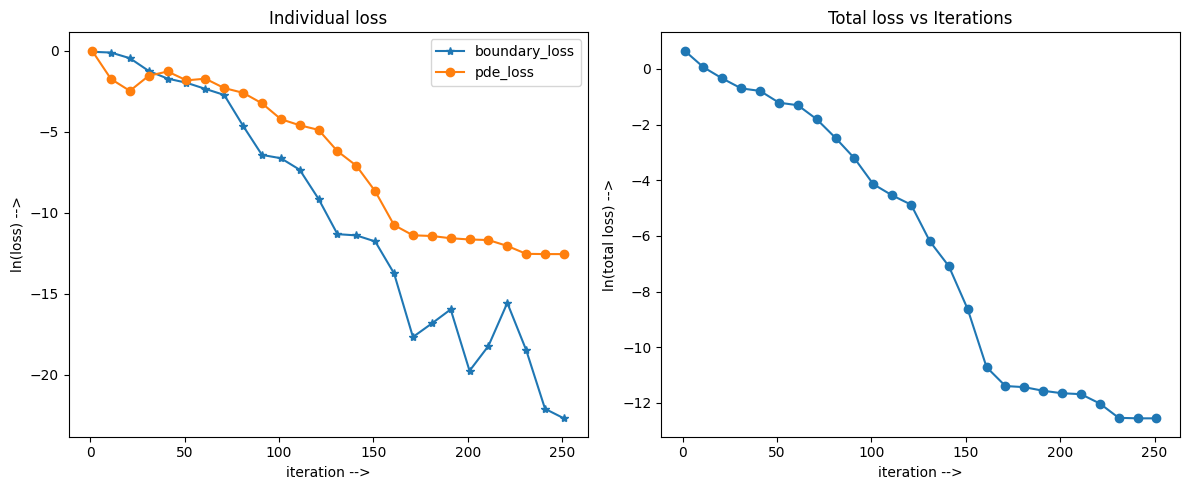

Displacement thickness: 0.6479508280754089
Momentum thickness: 0.29243412613868713
Shape factor: 2.2157154083251953
Wall skin friction coefficient: 2.4652726650238037


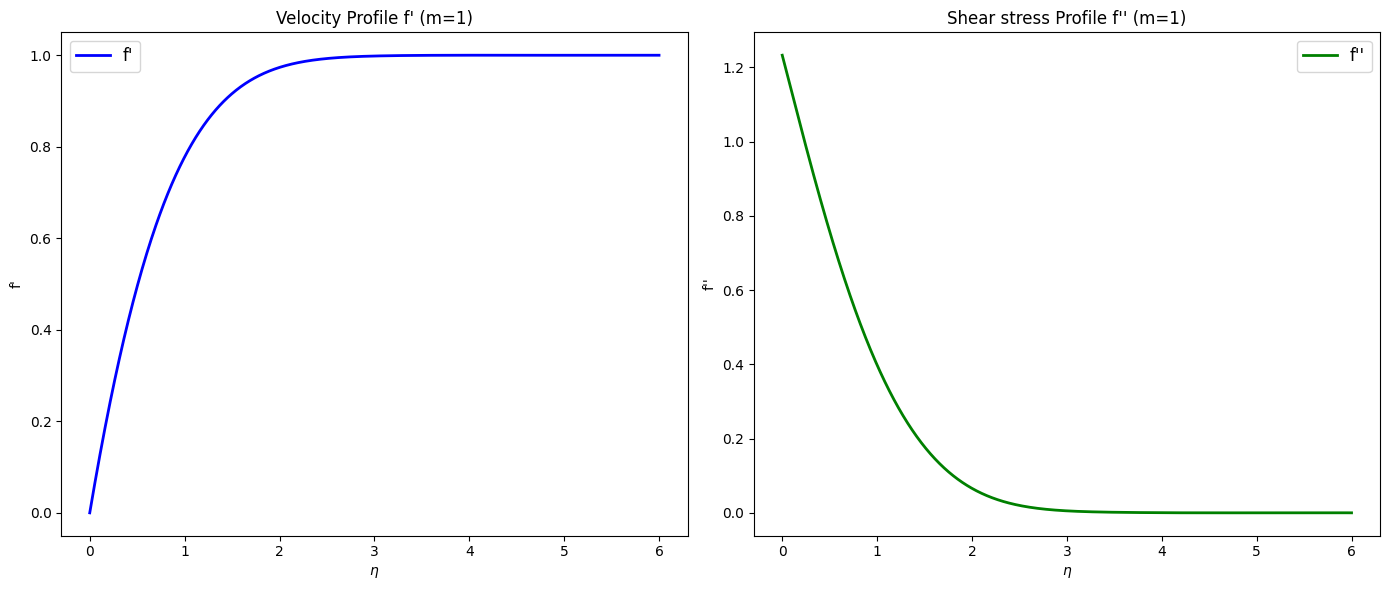

In [2]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim
import numpy as np   
import matplotlib.pyplot as plt
from numpy import trapz 


np.random.seed(941)
torch.manual_seed(11)
eta = np.linspace(0, 6, 1000)[:, None]
eta_min = eta[[0]]
eta_max = eta[[-1]]

# stagnation point flow 
m = 1
bc = eta[[0, -1]]
f_bc = np.array([[0],[1]])


eta = torch.from_numpy(eta).float()
eta_min = torch.from_numpy(eta_min).float()
eta_max = torch.from_numpy(eta_max).float()
bc = torch.from_numpy(bc).float()
f_bc = torch.from_numpy(f_bc).float()

class NN(nn.Module):
    
    def __init__(self, layers):
        super().__init__()
        
        # activation function
        self.activation = nn.Tanh()

        # loss function
        self.loss_function = nn.MSELoss(reduction='mean')

        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        self.iter = 0
        self.Lbc = []
        self.Lpde = []
        self.Ltotal = [] 

    def forward(self, x):
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        # scaling of the data
        x = (x - eta_min) / (eta_max - eta_min)

        for i in range(len(layers) - 2):
            z = self.linears[i](x)
            x = self.activation(z)

        a = self.linears[-1](x)
        return a

    def bc_loss(self, x, y):
        # BC1
        x1 = x[[0]]
        y1 = y[[0]]

        g1 = x1.clone()
        g1.requires_grad = True
        f1 = self.forward(g1)
        f_etab1 = autograd.grad(f1, g1, torch.ones([x1.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        # BC2
        x2 = x[[1]]
        y2 = y[[1]]
        g2 = x2.clone()
        g2.requires_grad = True
        f2 = self.forward(g2)
        f_etab2 = autograd.grad(f2, g2, torch.ones([x2.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        loss_bc1 = self.loss_function(f1, y1) + self.loss_function(f_etab1, torch.zeros_like(f_etab1))
        loss_bc2 = self.loss_function(f_etab2, y2)
        loss_bc = loss_bc1 + loss_bc2
        self.Lbc.append(loss_bc.item())
        return loss_bc
    
    def PDE(self, x):
        g3 = x.clone()
        g3.requires_grad = True
        f3 = self.forward(g3)

        f_eta = autograd.grad(f3, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta2 = autograd.grad(f_eta, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta3 = autograd.grad(f_eta2, g3, torch.ones([g3.shape[0], 1]), create_graph=True)[0]

        # Falkner-Skan differential equation
        pde = f_eta3 + ((m + 1) / 2) * f3 * f_eta2 + m * (1 - (f_eta)**2)

        loss_pde = self.loss_function(pde, torch.zeros_like(pde))
        self.Lpde.append(loss_pde.item())
        return loss_pde

    def loss(self, x, xb, yb):
        loss1 = self.bc_loss(xb, yb)
        loss2 = self.PDE(x)

        total_loss = abs(loss1) + abs(loss2)
        self.Ltotal.append(total_loss.item())  
        return total_loss
    
    def closure(self):
        optimizer.zero_grad()

        loss = self.loss(eta, bc, f_bc)

        loss.backward()

        self.iter += 1

        if self.iter % 100 == 0:
            print(f'Iteration {self.iter}: Loss = {loss.item()}')
            
        return loss    
    
    def test(self, x):
        x.requires_grad = True
        pred_result = self.forward(x)
        f_d = autograd.grad(pred_result, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_dd = autograd.grad(f_d, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        pred_result = pred_result.detach().numpy()
        f_d = f_d.detach().numpy()
        f_dd = f_dd.detach().numpy()

        return pred_result, f_d, f_dd

# 1 hidden layer with 20 neurons
layers = [1, 20, 1]

pinn = NN(layers)

max_iterations = 5000  
optimizer = torch.optim.LBFGS(pinn.parameters(), lr=0.1, max_iter=max_iterations,
                              tolerance_grad=1e-7, tolerance_change=1e-10,
                              history_size=500, line_search_fn='strong_wolfe')

optimizer.step(pinn.closure)

print(f'Total iterations: {pinn.iter}')
Lbc_list = pinn.Lbc
Lpde_list = pinn.Lpde
Ltotal_list = pinn.Ltotal

# loss vs iterations
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.arange(1, len(Lbc_list) + 1)[::10], np.log(np.array(Lbc_list)[::10]), marker='*', label='boundary_loss')
plt.plot(np.arange(1, len(Lpde_list) + 1)[::10], np.log(np.array(Lpde_list)[::10]), marker='o', label='pde_loss')
plt.legend()
plt.xlabel('iteration -->')
plt.ylabel('ln(loss) -->')
plt.title('Individual loss')

plt.subplot(122)
plt.plot(np.arange(1, len(Ltotal_list) + 1)[::10], np.log(np.array(Ltotal_list)[::10]), marker='o')
plt.title('Total loss vs Iterations')
plt.xlabel('iteration -->')
plt.ylabel('ln(total loss) -->')
plt.tight_layout()
plt.show()

fp, fp_d, fp_dd = pinn.test(eta)

eta = eta.detach().numpy()
fp = fp[:, 0]
fp_d = fp_d[:, 0]
fp_dd = fp_dd[:, 0]
eta = eta[:, 0]

# Displacement thickness (delta_star)
delta_star = trapz(1 - fp_d, eta)

# Momentum thickness (theta)
theta = trapz(fp_d * (1 - fp_d), eta)

# Shape factor (H)
H = delta_star / theta

# Wall skin friction coefficient (Cf)
Cf = 2 * fp_dd[0]

print(f'Displacement thickness: {delta_star}')
print(f'Momentum thickness: {theta}')
print(f'Shape factor: {H}')
print(f'Wall skin friction coefficient: {Cf}')


plt.figure(figsize=(14, 6))


plt.subplot(121)
plt.plot(eta, fp_d, label="f'", c='blue', linewidth=2)
plt.title("Velocity Profile f' (m=1)")
plt.xlabel(r'$\eta$')
plt.ylabel("f'")
plt.legend(fontsize=12)


plt.subplot(122)
plt.plot(eta, fp_dd, label="f''", c='green', linewidth=2)
plt.title("Shear stress Profile f'' (m=1)")
plt.xlabel(r'$\eta$')
plt.ylabel("f''")
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()


## Faulkner - Skan boundary layer equation:(Formulation A)
$\begin{align}
f''' + ff'' + beta(1 - (f')^2) = 0
\end{align}$

### Boundary Conditions:
$$\eta = 0 : f(0) = f'(0) = 0$$
$$ \eta -> infinity : f'(eta) = 1 $$

### For Flat plate ( Formulation A ) using PINN

Iteration 100: Loss = 0.0066467951983213425
Iteration 200: Loss = 0.0003263117978349328
Iteration 300: Loss = 0.00020430883159860969
Iteration 400: Loss = 0.00014235376147553325
Iteration 500: Loss = 0.00010248630860587582
Iteration 600: Loss = 5.30372817593161e-05
Iteration 700: Loss = 3.5448796552373096e-05
Iteration 800: Loss = 1.91753661056282e-05
Iteration 900: Loss = 4.847771833738079e-06
Total iterations: 999


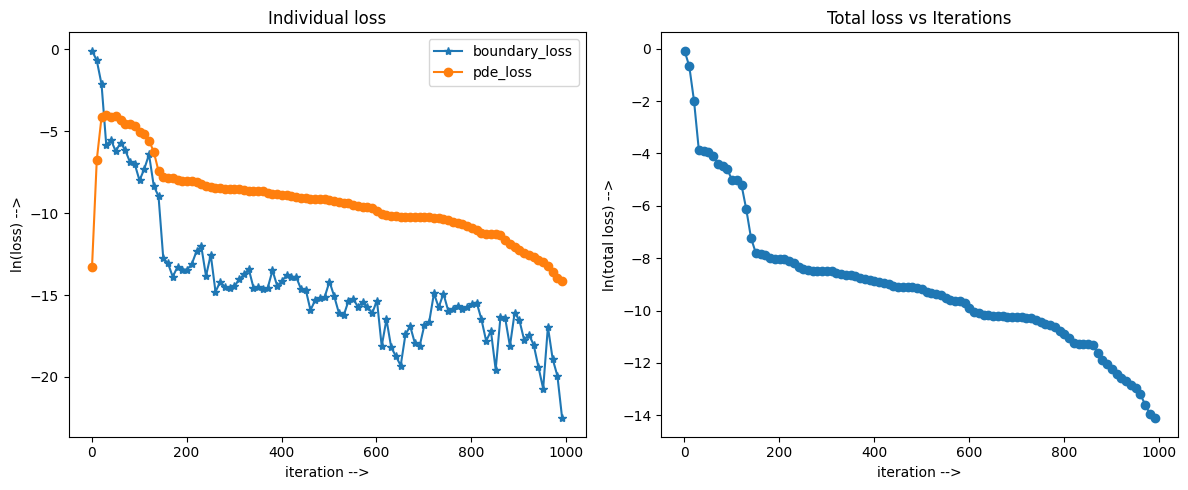

Displacement thickness: 1.2170660495758057
Momentum thickness: 0.4697483479976654
Shape factor: 2.5908894538879395
Wall skin friction coefficient: 0.9391915202140808


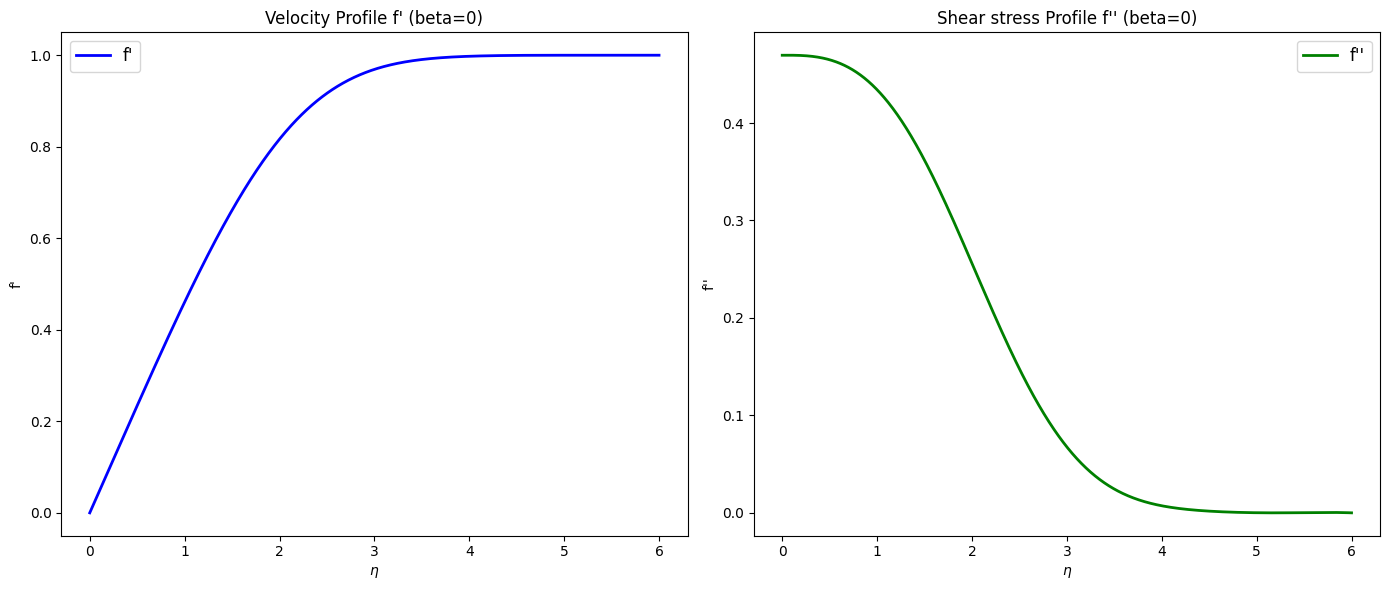

In [3]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim
import numpy as np   
import matplotlib.pyplot as plt
from numpy import trapz  


np.random.seed(941)
torch.manual_seed(11)
eta = np.linspace(0, 6, 1000)[:, None]
eta_min = eta[[0]]
eta_max = eta[[-1]]

 # flat plate case
beta = 0 
bc = eta[[0, -1]]
f_bc = np.array([[0],[1]])


eta = torch.from_numpy(eta).float()
eta_min = torch.from_numpy(eta_min).float()
eta_max = torch.from_numpy(eta_max).float()
bc = torch.from_numpy(bc).float()
f_bc = torch.from_numpy(f_bc).float()

class NN(nn.Module):
    
    def __init__(self, layers):  
        super().__init__()  
        
        # activation function
        self.activation = nn.Tanh()

        # loss function
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        self.iter = 0
        self.Lbc = []
        self.Lpde = []
        self.Ltotal = []  


    def forward(self, x):
        
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        # scaling of the data
        x = (x - eta_min) / (eta_max - eta_min)

        for i in range(len(layers) - 2):
            z = self.linears[i](x)
            x = self.activation(z)

        a = self.linears[-1](x)
        return a

    def bc_loss(self, x, y):
        # BC1
        x1 = x[[0]]
        y1 = y[[0]]

        g1 = x1.clone()
        g1.requires_grad = True
        f1 = self.forward(g1)
        f_etab1 = autograd.grad(f1, g1, torch.ones([x1.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        # BC2
        x2 = x[[1]]
        y2 = y[[1]]
        g2 = x2.clone()
        g2.requires_grad = True
        f2 = self.forward(g2)
        f_etab2 = autograd.grad(f2, g2, torch.ones([x2.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        loss_bc1 = self.loss_function(f1, y1) + self.loss_function(f_etab1, torch.zeros_like(f_etab1))
        loss_bc2 = self.loss_function(f_etab2, y2)
        loss_bc = loss_bc1 + loss_bc2
        self.Lbc.append(loss_bc.item())
        return loss_bc
    
    def PDE(self, x):
        g3 = x.clone()
        g3.requires_grad = True
        f3 = self.forward(g3)

        f_eta = autograd.grad(f3, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta2 = autograd.grad(f_eta, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta3 = autograd.grad(f_eta2, g3, torch.ones([g3.shape[0], 1]), create_graph=True)[0]

        # Falkner-Skan differential equation
        pde = f_eta3 + f3 * f_eta2 + beta * (1 - (f_eta)**2)

        loss_pde = self.loss_function(pde, torch.zeros_like(pde))
        self.Lpde.append(loss_pde.item())
        return loss_pde

    def loss(self, x, xb, yb):
        loss1 = self.bc_loss(xb, yb)
        loss2 = self.PDE(x)

        total_loss = abs(loss1) + abs(loss2)
        self.Ltotal.append(total_loss.item())  
        return total_loss
    
    def closure(self):
        optimizer.zero_grad()

        loss = self.loss(eta, bc, f_bc)

        loss.backward()

        self.iter += 1
        if self.iter % 100 == 0:
            print(f'Iteration {self.iter}: Loss = {loss.item()}')
            
        return loss    
    
    def test(self, x):
        x.requires_grad = True
        pred_result = self.forward(x)
        f_d = autograd.grad(pred_result, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_dd = autograd.grad(f_d, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        pred_result = pred_result.detach().numpy()
        f_d = f_d.detach().numpy()
        f_dd = f_dd.detach().numpy()

        return pred_result, f_d, f_dd

# 1 hidden layer with 20 neurons
layers = [1, 20, 1]

pinn = NN(layers)

max_iterations = 5000  
optimizer = torch.optim.LBFGS(pinn.parameters(), lr=0.1, max_iter=max_iterations,
                              tolerance_grad=1e-7, tolerance_change=1e-10,
                              history_size=500, line_search_fn='strong_wolfe')

optimizer.step(pinn.closure)

print(f'Total iterations: {pinn.iter}')
Lbc_list = pinn.Lbc
Lpde_list = pinn.Lpde
Ltotal_list = pinn.Ltotal

# loss vs iterations
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.arange(1, len(Lbc_list) + 1)[::10], np.log(np.array(Lbc_list)[::10]), marker='*', label='boundary_loss')
plt.plot(np.arange(1, len(Lpde_list) + 1)[::10], np.log(np.array(Lpde_list)[::10]), marker='o', label='pde_loss')
plt.legend()
plt.xlabel('iteration -->')
plt.ylabel('ln(loss) -->')
plt.title('Individual loss')

plt.subplot(122)
plt.plot(np.arange(1, len(Ltotal_list) + 1)[::10], np.log(np.array(Ltotal_list)[::10]), marker='o')
plt.title('Total loss vs Iterations')
plt.xlabel('iteration -->')
plt.ylabel('ln(total loss) -->')
plt.tight_layout()
plt.show()

fp, fp_d, fp_dd = pinn.test(eta)

eta = eta.detach().numpy()
fp = fp[:, 0]
fp_d = fp_d[:, 0]
fp_dd = fp_dd[:, 0]
eta = eta[:, 0]

# Displacement thickness (delta_star)
delta_star = trapz(1 - fp_d, eta)

# Momentum thickness (theta)
theta = trapz(fp_d * (1 - fp_d), eta)

# Shape factor (H)
H = delta_star / theta

# Wall skin friction coefficient (Cf)
Cf = 2 * fp_dd[0]

print(f'Displacement thickness: {delta_star}')
print(f'Momentum thickness: {theta}')
print(f'Shape factor: {H}')
print(f'Wall skin friction coefficient: {Cf}')

plt.figure(figsize=(14, 6))


plt.subplot(121)
plt.plot(eta, fp_d, label="f'", c='blue', linewidth=2)
plt.title("Velocity Profile f' (beta=0)")
plt.xlabel(r'$\eta$')
plt.ylabel("f'")
plt.legend(fontsize=12)


plt.subplot(122)
plt.plot(eta, fp_dd, label="f''", c='green', linewidth=2)
plt.title("Shear stress Profile f'' (beta=0)")
plt.xlabel(r'$\eta$')
plt.ylabel("f''")
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

### Stagnation point flow (  Formulation A ) using PINN

Iteration 100: Loss = 0.016376769170165062
Iteration 200: Loss = 8.714838259038515e-06
Total iterations: 256


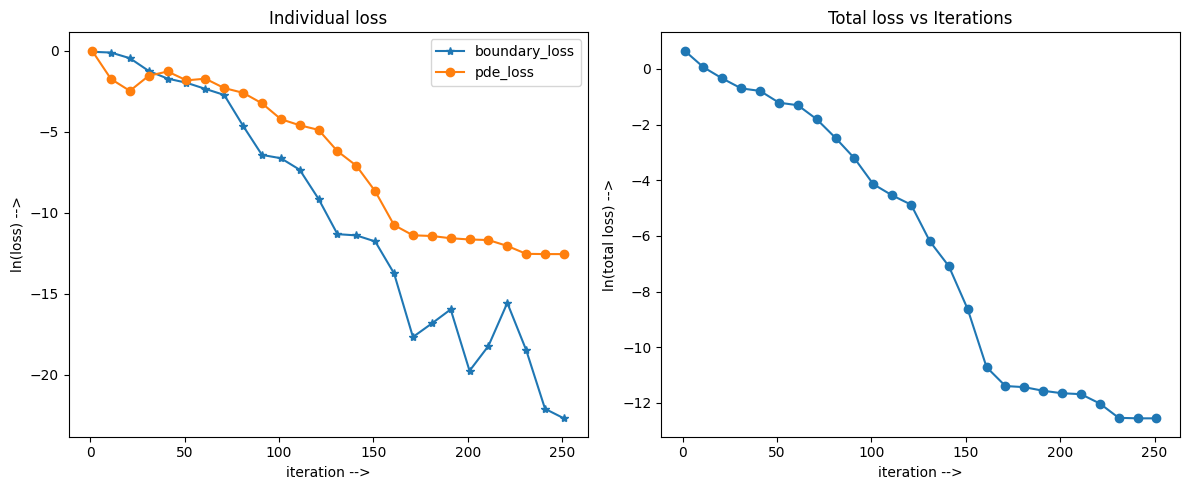

Displacement thickness: 0.6479508280754089
Momentum thickness: 0.29243412613868713
Shape factor: 2.2157154083251953
Wall skin friction coefficient: 2.4652726650238037


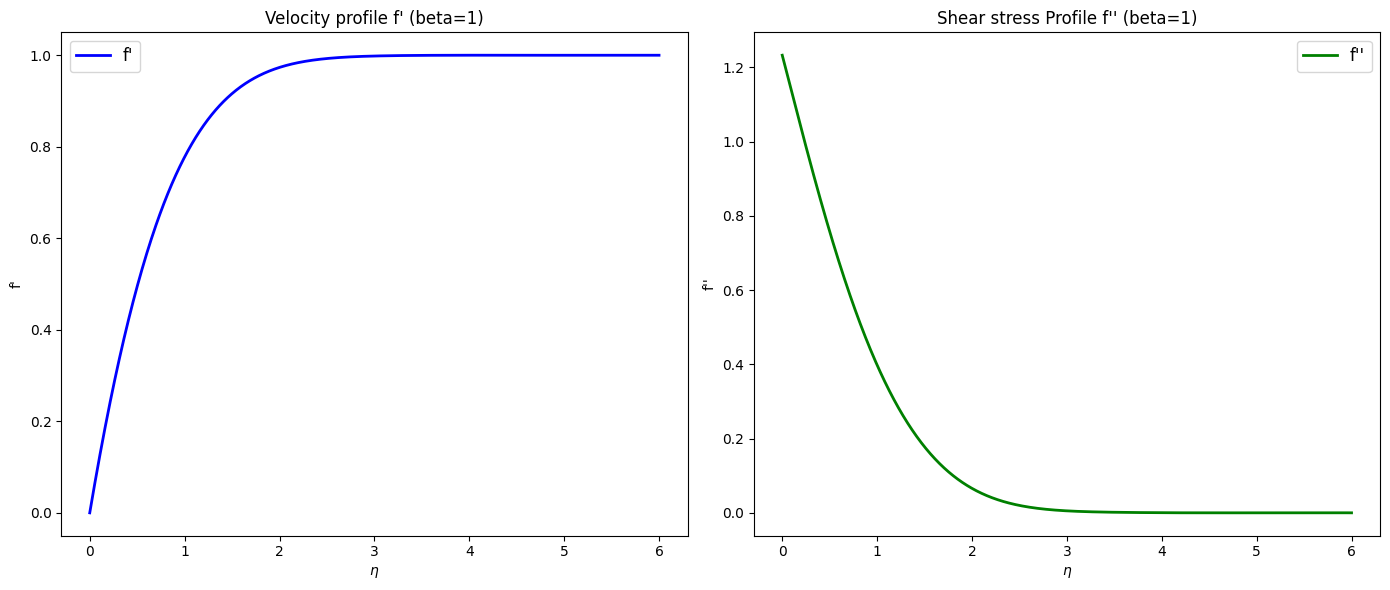

In [4]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.optim
import numpy as np   
import matplotlib.pyplot as plt
from numpy import trapz  


np.random.seed(941)
torch.manual_seed(11)
eta = np.linspace(0, 6, 1000)[:, None]
eta_min = eta[[0]]
eta_max = eta[[-1]]

# stagnation point case
beta = 1
bc = eta[[0, -1]]
f_bc = np.array([[0],[1]])


eta = torch.from_numpy(eta).float()
eta_min = torch.from_numpy(eta_min).float()
eta_max = torch.from_numpy(eta_max).float()
bc = torch.from_numpy(bc).float()
f_bc = torch.from_numpy(f_bc).float()

class NN(nn.Module):
    
    def __init__(self, layers):  
        super().__init__()  
        
        # activation function
        self.activation = nn.Tanh()

        # loss function
        self.loss_function = nn.MSELoss(reduction='mean')
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])

        self.iter = 0
        self.Lbc = []
        self.Lpde = []
        self.Ltotal = []  


    def forward(self, x):
        
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)

        # scaling of the data
        x = (x - eta_min) / (eta_max - eta_min)

        for i in range(len(layers) - 2):
            z = self.linears[i](x)
            x = self.activation(z)

        a = self.linears[-1](x)
        return a

    def bc_loss(self, x, y):
        # BC1
        x1 = x[[0]]
        y1 = y[[0]]

        g1 = x1.clone()
        g1.requires_grad = True
        f1 = self.forward(g1)
        f_etab1 = autograd.grad(f1, g1, torch.ones([x1.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        # BC2
        x2 = x[[1]]
        y2 = y[[1]]
        g2 = x2.clone()
        g2.requires_grad = True
        f2 = self.forward(g2)
        f_etab2 = autograd.grad(f2, g2, torch.ones([x2.shape[0], 1]), retain_graph=True, create_graph=True)[0]

        loss_bc1 = self.loss_function(f1, y1) + self.loss_function(f_etab1, torch.zeros_like(f_etab1))
        loss_bc2 = self.loss_function(f_etab2, y2)
        loss_bc = loss_bc1 + loss_bc2
        self.Lbc.append(loss_bc.item())
        return loss_bc
    
    def PDE(self, x):
        g3 = x.clone()
        g3.requires_grad = True
        f3 = self.forward(g3)

        f_eta = autograd.grad(f3, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta2 = autograd.grad(f_eta, g3, torch.ones([g3.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_eta3 = autograd.grad(f_eta2, g3, torch.ones([g3.shape[0], 1]), create_graph=True)[0]

        # Falkner-Skan differential equation
        pde = f_eta3 + f3 * f_eta2 + beta * (1 - (f_eta)**2)

        loss_pde = self.loss_function(pde, torch.zeros_like(pde))
        self.Lpde.append(loss_pde.item())
        return loss_pde

    def loss(self, x, xb, yb):
        loss1 = self.bc_loss(xb, yb)
        loss2 = self.PDE(x)

        total_loss = abs(loss1) + abs(loss2)
        self.Ltotal.append(total_loss.item())  
        return total_loss
    
    def closure(self):
        optimizer.zero_grad()

        loss = self.loss(eta, bc, f_bc)

        loss.backward()

        self.iter += 1
        if self.iter % 100 == 0:
            print(f'Iteration {self.iter}: Loss = {loss.item()}')
            
        return loss    
    
    def test(self, x):
        x.requires_grad = True
        pred_result = self.forward(x)
        f_d = autograd.grad(pred_result, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        f_dd = autograd.grad(f_d, x, torch.ones([x.shape[0], 1]), retain_graph=True, create_graph=True)[0]
        pred_result = pred_result.detach().numpy()
        f_d = f_d.detach().numpy()
        f_dd = f_dd.detach().numpy()

        return pred_result, f_d, f_dd

# 1 hidden layer with 20 neurons
layers = [1, 20, 1]

pinn = NN(layers)

max_iterations = 5000  
optimizer = torch.optim.LBFGS(pinn.parameters(), lr=0.1, max_iter=max_iterations,
                              tolerance_grad=1e-7, tolerance_change=1e-10,
                              history_size=500, line_search_fn='strong_wolfe')

optimizer.step(pinn.closure)

print(f'Total iterations: {pinn.iter}')
Lbc_list = pinn.Lbc
Lpde_list = pinn.Lpde
Ltotal_list = pinn.Ltotal

# loss vs iterations
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(np.arange(1, len(Lbc_list) + 1)[::10], np.log(np.array(Lbc_list)[::10]), marker='*', label='boundary_loss')
plt.plot(np.arange(1, len(Lpde_list) + 1)[::10], np.log(np.array(Lpde_list)[::10]), marker='o', label='pde_loss')
plt.legend()
plt.xlabel('iteration -->')
plt.ylabel('ln(loss) -->')
plt.title('Individual loss')

plt.subplot(122)
plt.plot(np.arange(1, len(Ltotal_list) + 1)[::10], np.log(np.array(Ltotal_list)[::10]), marker='o')
plt.title('Total loss vs Iterations')
plt.xlabel('iteration -->')
plt.ylabel('ln(total loss) -->')
plt.tight_layout()
plt.show()

fp, fp_d, fp_dd = pinn.test(eta)

eta = eta.detach().numpy()
fp = fp[:, 0]
fp_d = fp_d[:, 0]
fp_dd = fp_dd[:, 0]
eta = eta[:, 0]

# Displacement thickness (delta_star)
delta_star = trapz(1 - fp_d, eta)

# Momentum thickness (theta)
theta = trapz(fp_d * (1 - fp_d), eta)

# Shape factor (H)
H = delta_star / theta

# Wall skin friction coefficient (Cf)
Cf = 2 * fp_dd[0]

print(f'Displacement thickness: {delta_star}')
print(f'Momentum thickness: {theta}')
print(f'Shape factor: {H}')
print(f'Wall skin friction coefficient: {Cf}')

plt.figure(figsize=(14, 6))


plt.subplot(121)
plt.plot(eta, fp_d, label="f'", c='blue', linewidth=2)
plt.title("Velocity profile f' (beta=1)")
plt.xlabel(r'$\eta$')
plt.ylabel("f'")
plt.legend(fontsize=12)


plt.subplot(122)
plt.plot(eta, fp_dd, label="f''", c='green', linewidth=2)
plt.title("Shear stress Profile f'' (beta=1)")
plt.xlabel(r'$\eta$')
plt.ylabel("f''")
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

### Conclusions 

**Observations**:
  - **Initial Phase**: For both Flat plate and Stagnation point flow the loss starts high and decreases significantly 
  - **Flat Plate (`m = 0`)**:
    -  velocity starts from 0 at the wall (η = 0) and increases smoothly to the free-stream value of 1 as η increases.
  - **Stagnation Point Flow (`m = 1`)**:
    - for stagnation point flow the velocity profile appears to be reaching the free-stream value much quicker than for the flat plate case
##### The loss for both cases follows a similar pattern, though Stagnation point flow converges slightly faster than Flat plate case
##### For both the formulations almost similar results were observed
